<a href="https://colab.research.google.com/github/victoriousvictor42/Sales-Forecasting/blob/main/Sales_Forecasting_Using_Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Time Series Forecating


---

## Objective
Forecast the next 12 months of product sales using time series models to identify trends, seasonality, and improve business planning.


---

## Delivarables


*   Time series decomposition - trend, seasonality, residuals
*   Modeling - ARIMA, Prophet, or LSTM
*   Evaluation metrics - MAE, RMSE
*   Forecast visualization - Line plots, confidence intervals







## 2. Import libraries

In [17]:
%pip install statsmodels prophet statsforecast --quiet --upgrade

In [18]:
# importing basic libraries for daa handling and visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for decomposing timeseries into trend, seasonality, residuals
from statsmodels.tsa.seasonal import seasonal_decompose

# forecasting library (AutoARIMA, SARIMA, etc)
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

# Prophet model for time series forecasting
from prophet import Prophet

# Evaluation metrics to measure forecasting accuracy
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

## 3. Generate Synthetic Sales Data

Since we don't use real sales data here, we generate a synthetic dataset for this dataset. This creates a realistic-looking sales time series with both randomness and trend.

---
### 3.1 Synthetic Data Generation


*   pd.date_range → Creates a monthly date range starting from January 2020 with 36 periods (3 years)
*   np.random.poisson → Simulates random sales values around a mean (λ=200)
*   np.linspace(0,100,36) → Adds a small upward trend over time
*   pd.DataFrame → Combines the dates and sales into a clean dataset







In [19]:
# Generate a date range of 36 months starting from Jan 2020
date_range = pd.date_range(start='2020-01-01',periods=36,freq='M')

# Create synthetic sales data with a base Poisson Distribution + upward trend
sales = np.random.poisson(lam=200,size=36) + np.linspace(0,100,36)

# Build Dataframe with Date and Sales values
df = pd.DataFrame({'Date':date_range,'Sales':sales.round(2)})


In [20]:
# Preview the first 5 rows
df.head()

,Date,Sales
0,2020-01-31,217.00
1,2020-02-29,189.86
2,2020-03-31,201.71
3,2020-04-30,197.57
4,2020-05-31,211.43


In [21]:
# Preview the last 5 rows
df.tail()

,Date,Sales
31,2022-08-31,282.57
32,2022-09-30,299.43
33,2022-10-31,280.29
34,2022-11-30,288.14
35,2022-12-31,308.00


In [22]:
df.shape

(36, 2)

there are 36 rows and 2 columns

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    36 non-null     datetime64[ns]
 1   Sales   36 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 708.0 bytes


In [24]:
# Summary statistics
df.describe()

,Date,Sales
count,36,36.000000
mean,2021-07-15 21:20:00,252.861111
min,2020-01-31 00:00:00,189.860000
25%,2020-10-23 06:00:00,229.750000
50%,2021-07-15 12:00:00,255.145000
75%,2022-04-07 12:00:00,280.610000
max,2022-12-31 00:00:00,308.000000
std,NaN,32.561507


## 4. Exploratory Data Analysis (EDA)

We perform EDA to understand our synthetic sales dataset and identify trends, seasonality, and anomalies.

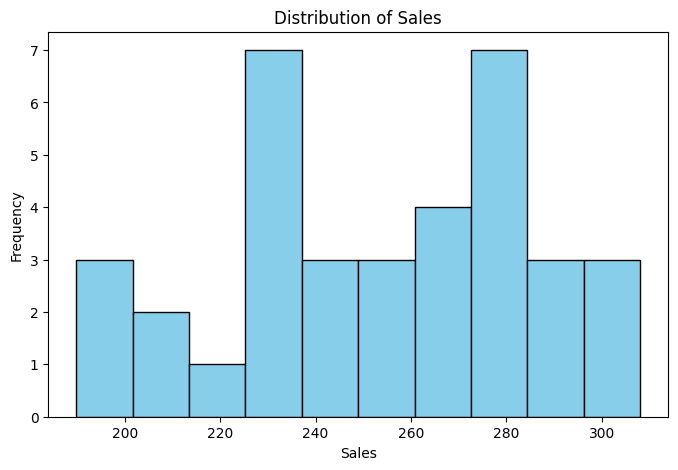

In [25]:
# Set figure size for the histogram
plt.figure(figsize=(8,5))

# Plot histogram of sales to visualize the distribution
plt.hist(df['Sales'],bins=10, color='skyblue', edgecolor='black')

# Add title and axis labels
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')

# Display the plot
plt.show()

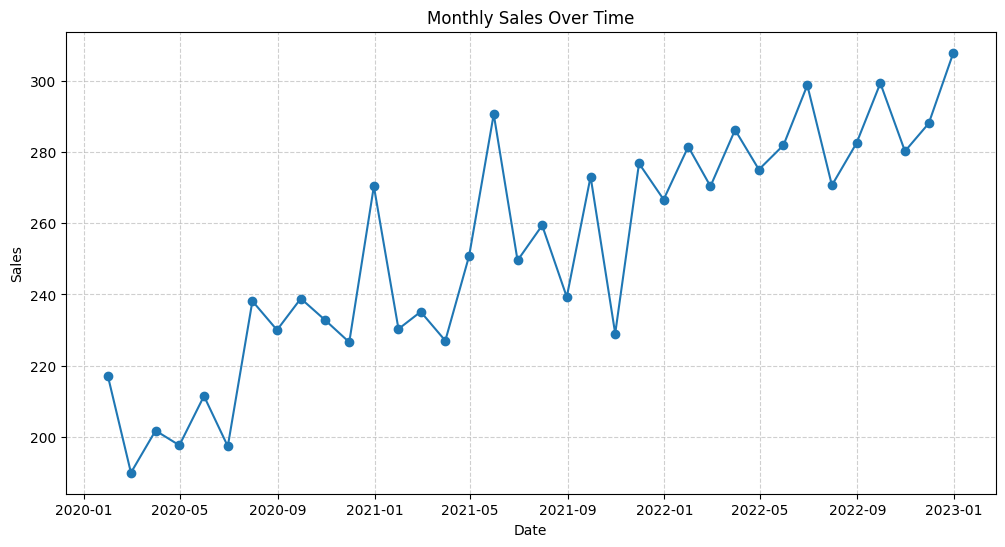

In [26]:
# Set figure size for the line plot
plt.figure(figsize=(12,6))

# Plot monthly sales over time with markers
plt.plot(df['Date'],df['Sales'],marker='o',linestyle='-')

# Add title and axis labels
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')

# Add grid for better readability
plt.grid(True,linestyle="--",alpha=0.6)

# Display the plot
plt.show()

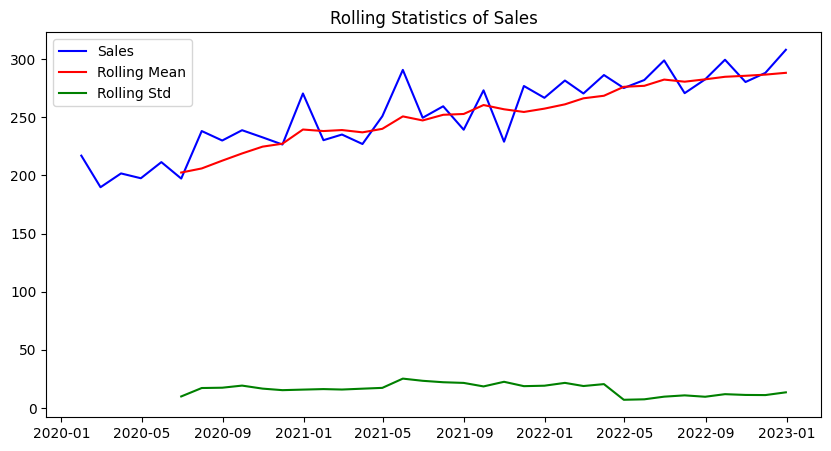

In [27]:
# calculate 6-month rolling mean and standard deviation
df_roll = df.copy()
df_roll['Rolling_Mean'] = df['Sales'].rolling(window=6).mean()
df_roll['RollingStd'] = df['Sales'].rolling(window=6).std()

# Set figure size for the plot
plt.figure(figsize=(10,5))

# Plot original sales, rolling mean, and rolling standard deviation
plt.plot(df['Date'], df['Sales'], label='Sales', color='blue')
plt.plot(df_roll['Date'], df_roll['Rolling_Mean'], label='Rolling Mean', color='red')
plt.plot(df_roll['Date'], df_roll['RollingStd'], label='Rolling Std', color='green')

# add legend and title
plt.legend()
plt.title('Rolling Statistics of Sales')

# Display the plot
plt.show()

Seasonal Decomposition helps us understand underlying patterns:


*   Trend → overall direction of sales
*   Seasonality → repeating yearly patterns
*   Residuals → random noise in the series





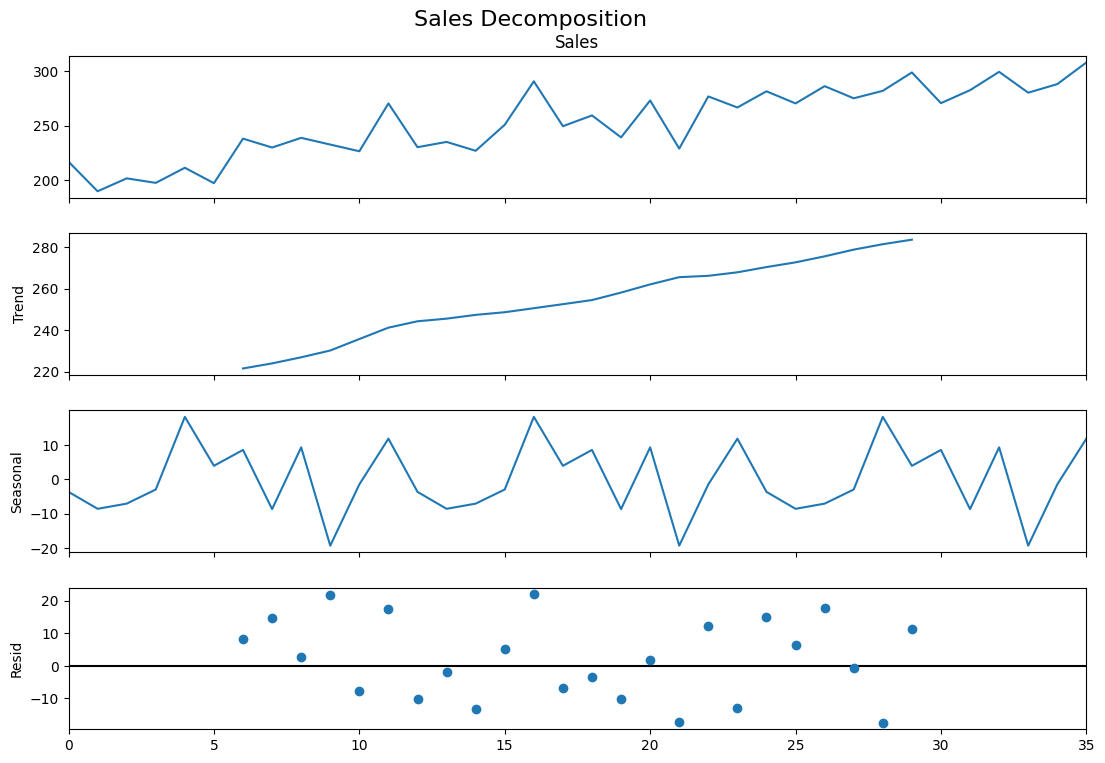

In [28]:
# Decompose the sales time series into trend, seasonality, and residuals
decomposition = seasonal_decompose(df['Sales'], model='additive', period=12)

# Plot the decomposition components
fig = decomposition.plot()
fig.set_size_inches(12,8)

# Add a main title for the decomposition plot
plt.suptitle("Sales Decomposition", fontsize=16)

# Display the plot
plt.show()

## 5. Model Training and Forecasting

In this step, we prepare the dataset and train AutoARIMA and Prophet models to forecast sales for the next 12 months. This allows us to analyze trends and compare model performance.

In [29]:
# Split the dataset into training (first 30 months) and testing (last 6 months)
train = df.iloc[:-6].copy()
test = df.iloc[-6:].copy()

# Prepare training data for Prophet/StatsForecast: rename columns to 'ds' and 'y' (target)
train = train.rename(columns={'Date':'ds','Sales':'y'})

# Add a unique ID column required by StatsForecast (useful for multiple time series)
train['unique_id'] = 'Sales'

train.head()

,ds,y,unique_id
0,2020-01-31,217.00,Sales
1,2020-02-29,189.86,Sales
2,2020-03-31,201.71,Sales
3,2020-04-30,197.57,Sales
4,2020-05-31,211.43,Sales


### 5.1 AutoARIMA Model

In [30]:
# season_length = 12 indicating monthhly data with yearly seasonality
sf = StatsForecast(models=[AutoARIMA(season_length=12)],freq='M')

# fit the AutoARIMA model on the training dataset
sf_fit = sf.fit(train)

# Forecast the next 12 months
sf_forecast = sf.predict(h=12)

# Display the first few forecasted values
print("\n AutoARIMA Forecast: \n")
print(sf_forecast.head())


 AutoARIMA Forecast: 

  unique_id         ds   AutoARIMA
0     Sales 2022-07-31  285.102417
1     Sales 2022-08-31  287.568306
2     Sales 2022-09-30  290.034195
3     Sales 2022-10-31  292.500084
4     Sales 2022-11-30  294.965973


### 5.2 Prophet Model

In [31]:
prophet_model = Prophet(yearly_seasonality=True)

# Fit the Prophet model on the training data
prophet_model.fit(train)

# Create a dataframe for future dates to forecast the next 12 months
future = prophet_model.make_future_dataframe(periods=12,freq='M')

# Generating forecasts for both training and future periods
forecast = prophet_model.predict(future)

# Display the first few forecasted values
forecast.head()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4ke4c18t/4pk8bf1m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4ke4c18t/63ju795m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56639', 'data', 'file=/tmp/tmp4ke4c18t/4pk8bf1m.json', 'init=/tmp/tmp4ke4c18t/63ju795m.json', 'output', 'file=/tmp/tmp4ke4c18t/prophet_model12788yw5/prophet_model-20250913105302.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:53:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:53:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-31,191.503810,205.958795,229.965049,191.503810,191.503810,26.849825,26.849825,26.849825,26.849825,26.849825,26.849825,0.0,0.0,0.0,218.353635
1,2020-02-29,194.370393,183.550100,206.744600,194.370393,194.370393,0.523143,0.523143,0.523143,0.523143,0.523143,0.523143,0.0,0.0,0.0,194.893536
2,2020-03-31,197.434671,188.769656,211.956991,197.434671,197.434671,3.204809,3.204809,3.204809,3.204809,3.204809,3.204809,0.0,0.0,0.0,200.639481
3,2020-04-30,200.400102,194.905514,217.848697,200.400102,200.400102,6.524171,6.524171,6.524171,6.524171,6.524171,6.524171,0.0,0.0,0.0,206.924273
4,2020-05-31,203.464380,217.616868,240.901552,203.464380,203.464380,26.075249,26.075249,26.075249,26.075249,26.075249,26.075249,0.0,0.0,0.0,229.539629


<Figure size 1200x600 with 0 Axes>

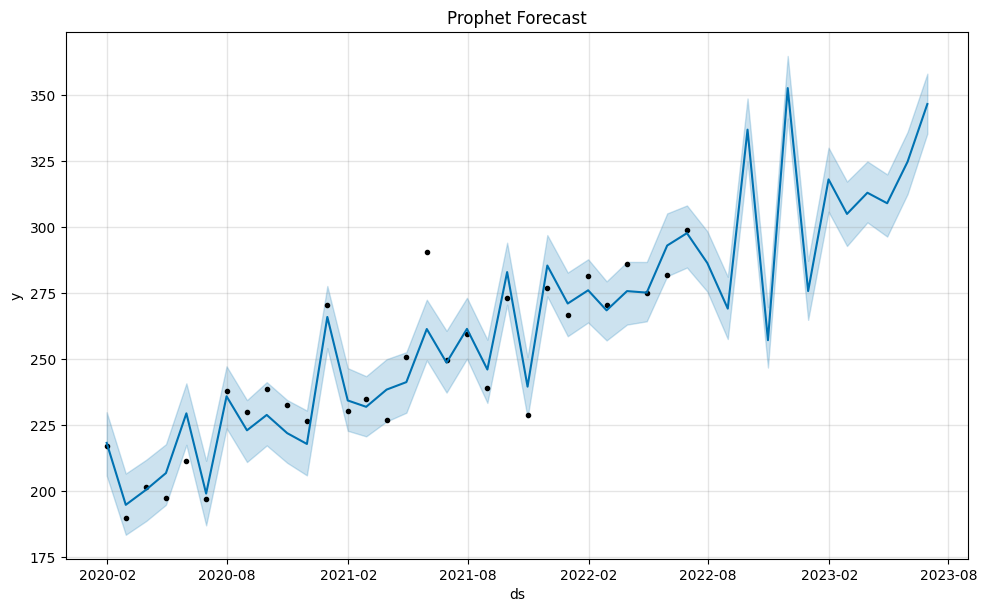

In [32]:
# Plot Prophet forecast
plt.figure(figsize=(12,6))
prophet_model.plot(forecast)
plt.title('Prophet Forecast')
plt.show()

## 6. Model Evaluation

We will evaluate the performance of the two models, AutoARIMA and Prophet, on the test dataset using common error metrics, such as, Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).

### 6.1 AutoARIMA Evaluation

In [36]:
# Extract AutoARIMA predictions for the test period
arima_pred = sf_forecast['AutoARIMA'].values[:len(test)] # match test length

# Calculate evaluation merics
mae_arima = mean_absolute_error(test['Sales'],arima_pred)
rmse_arima = np.sqrt(mean_squared_error(test['Sales'],arima_pred))

print("AutoARIMA Metrics:")
print(f"MAE: {mae_arima:.2f}")
print(f"RMSE: {rmse_arima:.2f}")

AutoARIMA Metrics:
MAE: 9.73
RMSE: 10.23


### 6.2 Prophet Evaluation

In [37]:
# Extract Prophet predictions for the test period
prophet_pred = forecast[['ds','yhat']].iloc[-6:].reset_index(drop=True)

# Calculate evaluation metrics
mae_prophet = mean_absolute_error(test['Sales'],prophet_pred['yhat'])
rmse_prophet = np.sqrt(mean_squared_error(test['Sales'],prophet_pred['yhat']))

print("Prophet Metrics:")
print(f"MAE: {mae_prophet:.2f}")
print(f"RMSE: {rmse_prophet:.2f}")

Prophet Metrics:
MAE: 31.30
RMSE: 33.21


## 7. Forecast Visualizations

We focus on visualizing forecasts from AutoARIMA and Prophet models, comparing them with actual sales to assess performance.


---

Defining a Plotting Function → Create plot_forecast() to display:


*   Training Data (Blue)
*   Testing Data (Green)


*   Model Forecasts (Red/Orange with dashed lines)




In [38]:
# Initializing the function
def plot_forecast(train, test, predictions, model_name):

  # Set figure size
  plt.figure(figsize=(12,6))

  # Plot training data as blue
  plt.plot(train.index, train['y'], label='Train', color='blue')

  # Plot testing data as green
  plt.plot(test.index, test['Sales'], label='Test', color='green')

  # Plot predictions as red/orange
  plt.plot(test.index, predictions, label=f'{model_name} Forecast', color='orange', linestyle='--')

  # Add title and axis labels
  plt.title(f'{model_name} Forecast vs Actual')
  plt.xlabel('Date')
  plt.ylabel('Sales')

  # Add legend and grid
  plt.legend()
  plt.grid(True, linestyle='--', alpha=0.6)

  # Display the plot
  plt.show()

### 7.1 AutoARIMA Forecast Plot

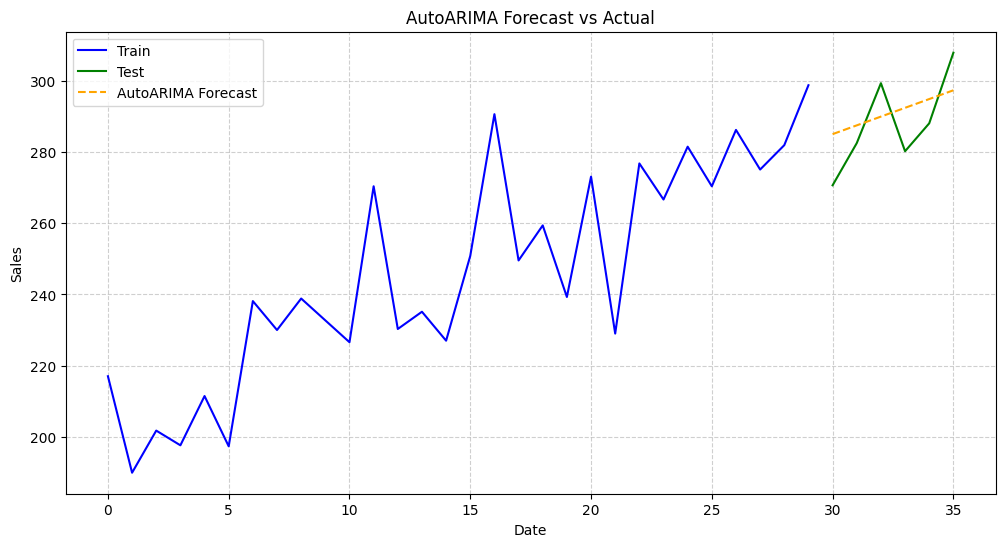

In [39]:
# Extract forecasted values for the test period
forecast_arima = sf_forecast['AutoARIMA'].values[:len(test)] # Align length with test set

# Plot the forecast
plot_forecast(train, test, forecast_arima, 'AutoARIMA')

### 7.2 Prophet Forecast Plot

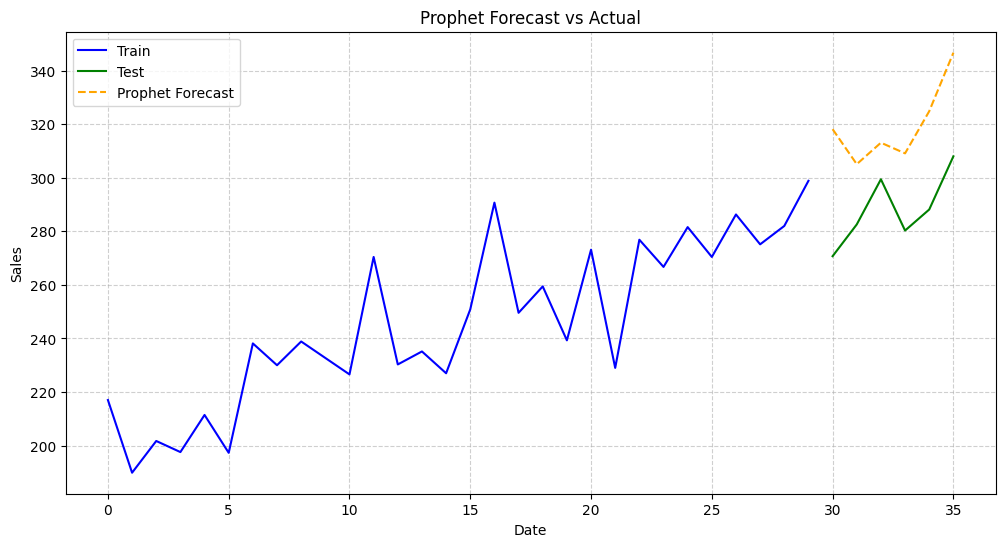

In [41]:
future = prophet_model.make_future_dataframe(periods=12,freq='M')
forecast = prophet_model.predict(future)

# Extract only the last 'len(test)' rows to align with test set
forecast_prophet = forecast.tail(len(test))

# predicted values
prophet_preds = forecast_prophet['yhat'].values

# Now plot correctly
plot_forecast(train, test, prophet_preds, 'Prophet')


### 7.3 Comparison of AutoARIMA vs Prophet Forecast




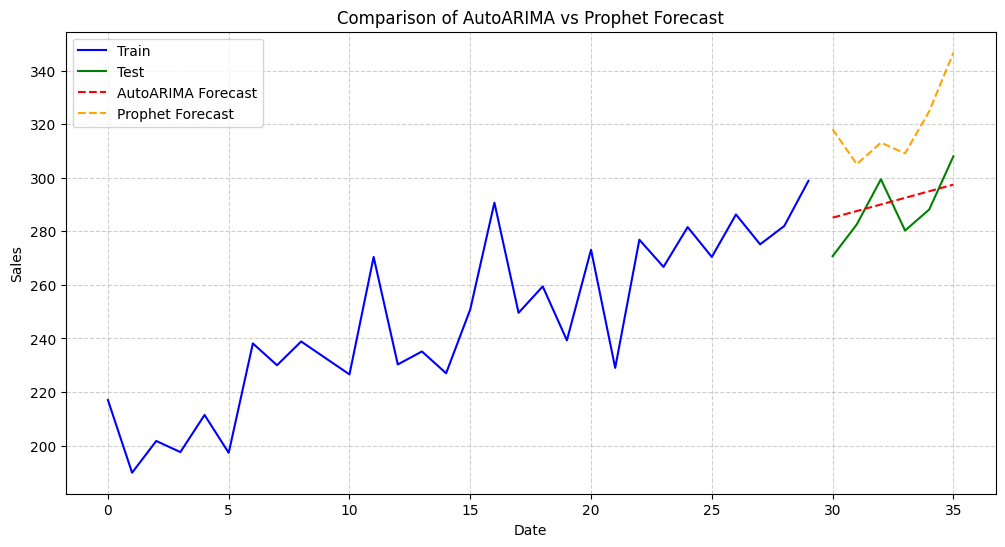

In [42]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train['y'], label='Train', color='blue')
plt.plot(test.index, test['Sales'], label='Test', color='green')
plt.plot(test.index, forecast_arima, label='AutoARIMA Forecast', color='red', linestyle='--')
plt.plot(test.index, prophet_preds, label='Prophet Forecast', color='orange', linestyle='--')
plt.title('Comparison of AutoARIMA vs Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

 ## 8. Conclusion

AutoARIMA outperforms Prophet with lower error values indicating it better captures the underlying sales patterns.


---

Future improvements:
*   Try SARIMA or Exponential Smoothing models
*   Incorporate exogeneous features (promotions, holedays)
*   Explore advanced Machine Learning/Deep Learning models like LSTM for forecasting


---

### Thank you! Please leave your advice in the comments



